# Comparison of standard MLP, Gaussian MLP and Gaussian Mixture MLP

## Regression example

### Imports

In [1]:
import os
path = os.getcwd()
if path.split(sep="\\")[-1]!='InternshipMatakos':
    os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics as tm

from src import evaluate
from src.evaluate import evaluate_regr, NLPD_standard_MLP_ensemble, NLPD_gmm
from utils import util
from utils import data_loaders
from utils.domain_split import hyperplane_split
from src.train_test import fit_regr, test_regr, fit_ensemble, test_regr_ensemble, fit_gmlp, fit_gmm, test_gmm
from src.model import MLP, GaussianMLP, GaussianMixtureMLP

# seed = np.random.randint(10000)
seed = 7141 #4092
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

I have specifically chosen a seed which produces a good domain split.

In [2]:
df = pd.read_csv("data/regression/airfoil.csv")
df.head()

,Frequency,AngleAttack,ChordLength,FreeStreamVelocity,SuctionSide,Sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Prepare data, split domain, hyperparameters (airfoil UCI dataset)

In [3]:
D = df.values
dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)
df[dom_idx].head()

# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

# Hyperparameters
n_classes = 1
n_features = X.shape[1]
n_epochs = 1000
n_hidden_1 = 100
n_hidden_2 = 10
n_hidden_3 = 100
learning_rate = 1e-3
weight_decay = 1e-4
batch_size_train = 64
batch_size_test = 64

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)

Found random direction n = [ 0.13666669 -0.21046149  0.37092866  0.44570104 -0.43332977 -0.64266321]
Found split with ratio r = 0.20093147039254824


### Training a MLP with MSE

In [4]:
model = MLP(n_features, n_classes, [100, 30, ], 'tanh').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_function = nn.MSELoss()

In [5]:
train_losses = fit_regr(model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print("Average Train MSE Loss:", avg_train_loss)

Average Train MSE Loss: 0.00021627978518760452


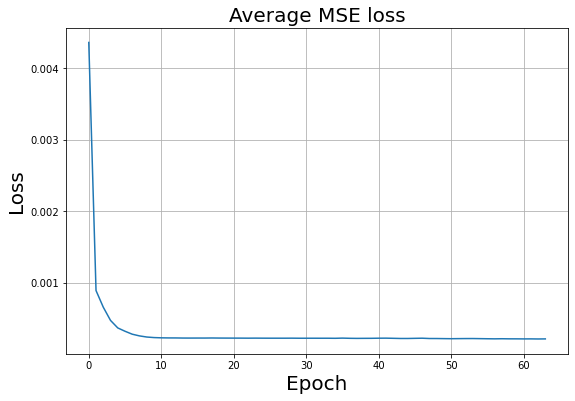

In [6]:
plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("Average MSE loss", fontsize=20)
plt.show()

In [7]:
avg_test_loss = test_regr(model, loss_function, test_loader, verbose=0, return_loss=True)

print(f"Average test loss = {avg_test_loss:.5f}")   

Average test loss = 0.00022


In [8]:
avg_OOD_loss = test_regr(model, loss_function, OOD_loader, verbose=0, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {(avg_OOD_loss / avg_train_loss) : .3f}")
print(f"Average OOD loss to test loss ratio: {(avg_OOD_loss / avg_test_loss) : .3f}")

Average OOD loss = 0.0009617600
Average OOD loss to train loss ratio:  4.447
Average OOD loss to test loss ratio:  4.369


### Training an ensemble of 30 MLPs with MSE

In [9]:
model = MLP(n_features, n_classes, [100, 30, ], 'tanh').to(device)
loss_function = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Loss curves for the ensemble's models:


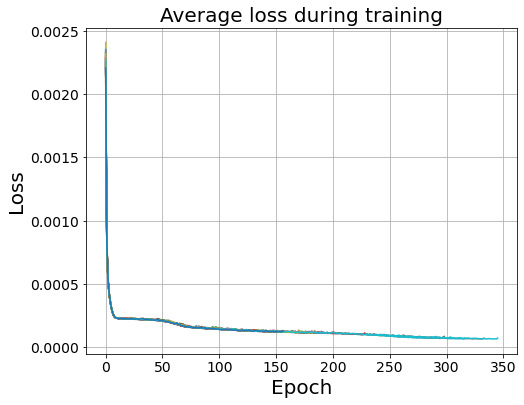

In [10]:
M = 30
print("Loss curves for the ensemble's models:")
ensemble = fit_ensemble(model, loss_function, M=M, plot=True, lr=learning_rate, loader=train_loader, verbose=0, 
                             early_stopping='train', n_epochs=n_epochs)


### Check MSE loss

In [11]:
# Test
avg_test_loss = test_regr_ensemble(ensemble, loss_function, test_loader, verbose=0, return_loss=True)
print(f"Average test loss = {avg_test_loss:.5f}")   

avg_OOD_loss = test_regr_ensemble(ensemble, loss_function, OOD_loader, verbose=0, return_loss=True)
print(f"\nAverage OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {(avg_OOD_loss / avg_train_loss) : .3f}")
print(f"Average OOD loss to test loss ratio: {(avg_OOD_loss / avg_test_loss) : .3f}")

Average test loss = 0.00009

Average OOD loss = 0.0006873780
Average OOD loss to train loss ratio:  3.178
Average OOD loss to test loss ratio:  7.329


### Check NLPD

We check the NLPD by assuming a gaussian with mean vector the outputs of the M models, and as variance the observed variance from the model outputs.

In [12]:
print("Train evaluation:")
NLPD_standard_MLP_ensemble(ensemble, train_loader, verbose=1)

print("\nTest evaluation:")
NLPD_standard_MLP_ensemble(ensemble, test_loader, verbose=1)

print("\nOOD evaluation:")
ood = NLPD_standard_MLP_ensemble(ensemble, OOD_loader, verbose=1)

Train evaluation:
Average NLPD = 1.089468
SD of NLPD = 5.808042
Total NLPD = 1045.8893

Test evaluation:
Average NLPD = 0.73317623
SD of NLPD = 4.7407
Total NLPD = 176.69547

OOD evaluation:
Average NLPD = 30.46244
SD of NLPD = 55.09118
Total NLPD = 9199.657


### Training a Gaussian MLP with NLL

A Gaussian MLP is a MLP that outputs a mean vector and a variance vector. We train it by minimizing the negative log-likelihood of the target values under a gaussian with that mean and variance.

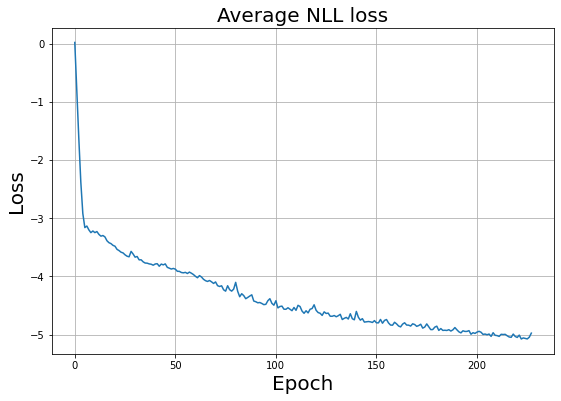

In [13]:
model = GaussianMLP(n_features, 1, [100, 30, ], 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train
train_losses = fit_gmlp(model, optimizer, train_loader, n_epochs, early_stopping=True, return_losses=True)

plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("Average NLL loss", fontsize=20)
plt.show()

### Check the MSE loss

Note that the MSE loss here is a lot higher since we are bottlenecking the function approximation by using a gaussian.

In [14]:
test_gmm(model, test_loader, verbose=1)

Average Test MSE Loss: 0.79211606


### Visual check of the fit (best we can do for high dimensions)

We plot for each sample the target value and the network output $\mu$ along with $\pm$ 2 standard deviations.

I have arbitrarily sorted the target values so that the plot is nicer to look at.

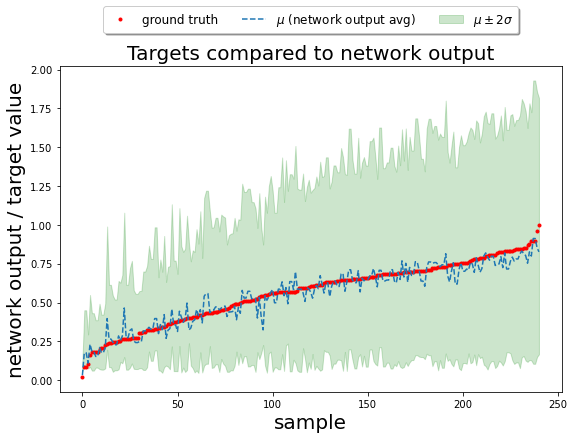

In [15]:
mus = []
varss = []
targets = []
for data, target in test_loader:
    mu, var = model(data)
    mus.append(mu.flatten())
    varss.append(var.flatten())
    targets.append(target)
    
mu = torch.cat(mus)
var = torch.cat(varss)
target = torch.cat(targets)

table = torch.empty( (len(target), 4) )
table[:, 0] = mu - 2*var.sqrt()
table[:, 1] = mu
table[:, 2] = mu + 2*var.sqrt()
table[:, 3] = target
table = table[torch.argsort(target)]

mu = table[:, 1].detach().cpu().numpy()
lower, upper = mu - table[:, 0].detach().cpu().numpy(), mu + table[:, 2].detach().cpu().numpy()
targets = table[:, 3].detach().cpu().numpy()
sample = torch.arange(0, len(targets)).detach().cpu().numpy()

plt.figure(figsize=(9, 6))
plt.plot(targets, 'r.', label='ground truth')
plt.plot(mu, '--', label=r'$\mu$ (network output avg)')
plt.fill_between(sample, lower, upper, color='g', alpha=0.2, label=r'$\mu \pm 2\sigma$')
plt.xlabel('sample', fontsize=20)
plt.ylabel('network output / target value', fontsize=20)
plt.title('Targets compared to network output', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.show()

### Training a Gaussian Mixture MLP (deep ensemble) with NLL

The ensemble model is a gaussian mixture model: 

$$ \mathcal{N}(\mu(x), \sigma^2 (x)) = \frac{1}{M} \sum_m \mathcal{N}(\mu_m (x), \sigma_m ^2)), $$

where the individual models are Gaussian MLPs with output $\mu_m(x)$ and $\sigma_m(x)$.

As noted in the paper, the GMM can be treated as a gaussian with

$$ \mu(x) = \frac{1}{M} \sum_m \mu_m (x), $$

$$ \sigma^2(x) = \frac{1}{M} \sum_m \big( \sigma^2 _m(x) + \mu^2 _m(x) \big) - \mu^2_m (x). $$

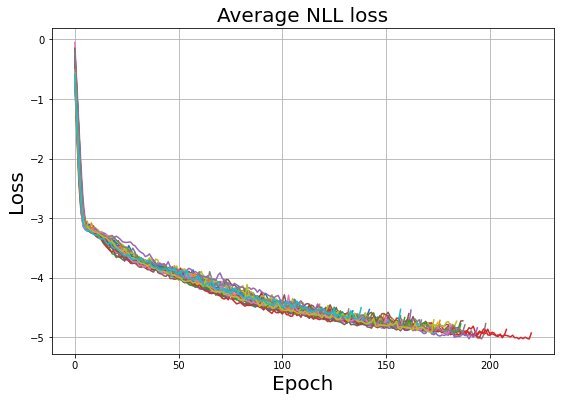

In [16]:
M = 30    # number of models to use in the ensemble
gmm = GaussianMixtureMLP(M, n_features, n_classes, [100, 30, ], 'tanh').to(device)
gmm_optimizers = []
for m in range(gmm.n_models):
    model = getattr(gmm, 'model_'+str(m))
    gmm_optimizers.append(torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay))

# Train
losses = fit_gmm(gmm, gmm_optimizers, train_loader, n_epochs, verbose=0, early_stopping=True, plot_loss=True)

### Check NLPD

In [17]:
print("Train evaluation:")
NLPD_gmm(gmm, train_loader, verbose=1)

print("\nTest evaluation:")
NLPD_gmm(gmm, test_loader, verbose=1)

print("\nOOD evaluation:")
ood = NLPD_gmm(gmm, OOD_loader, verbose=1)

Train evaluation:
Average NLPD = -1.5120507
SD of NLPD = 0.6336859
Total NLPD = -1451.5686

Test evaluation:
Average NLPD = -1.4997914
SD of NLPD = 0.57004535
Total NLPD = -361.4497

OOD evaluation:
Average NLPD = 0.21346192
SD of NLPD = 2.586136
Total NLPD = 64.4655


For comparison, Arno's GPflow baseline model had an average NLPD value of -1.37 on the airfoil dataset.

### Check the MSE loss 

In [18]:
test_gmm(gmm, test_loader, verbose=1)

Average Test MSE Loss: 0.79602318


### Visual check of the fit (best we can do for high dimensions)

We plot for each sample the target value and the network output $\mu$ along with $\pm$ 2 standard deviations.

I have arbitrarily sorted the target values so that the plot is nicer to look at.

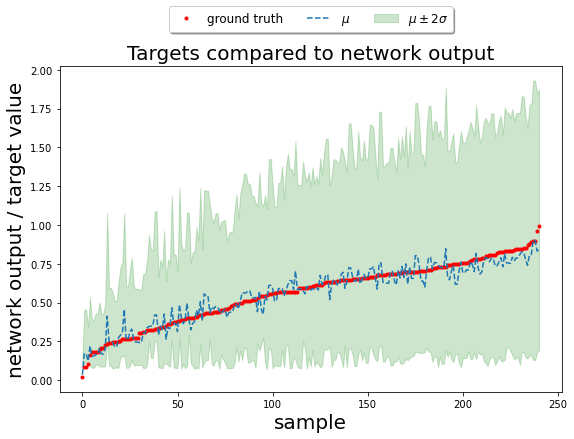

In [19]:
mus = []
varss = []
targets = []
for data, target in test_loader:
    mu, var = gmm(data)
    mus.append(mu.flatten())
    varss.append(var.flatten())
    targets.append(target)
    
mu = torch.cat(mus)
var = torch.cat(varss)
target = torch.cat(targets)

table = torch.empty( (len(target), 4) )
table[:, 0] = mu - 2*var.sqrt()
table[:, 1] = mu
table[:, 2] = mu + 2*var.sqrt()
table[:, 3] = target
table = table[torch.argsort(target)]

mu = table[:, 1].detach().cpu().numpy()
lower, upper = mu - table[:, 0].detach().cpu().numpy(), mu + table[:, 2].detach().cpu().numpy()
targets = table[:, 3].detach().cpu().numpy()
sample = torch.arange(0, len(targets)).detach().cpu().numpy()

plt.figure(figsize=(9, 6))
plt.plot(targets, 'r.', label='ground truth')
plt.plot(mu, '--', label=r'$\mu$')
plt.fill_between(sample, lower, upper, color='g', alpha=0.2, label=r'$\mu \pm 2\sigma$')
plt.xlabel('sample', fontsize=20)
plt.ylabel('network output / target value', fontsize=20)
plt.title('Targets compared to network output', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.show()